## Background

The model given below was trained using X-ray images found at https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia or http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5. There is a class imbalance so an undersample was taken from the majority class to even classes. Each image during the training phase were standardized using Tensorflow's per_image_standardization function - I found that applying augmentations to the images did not make a significant difference in improving model metrics. I used the first two layers from Keras' supplied VGG16 model (keras.applications) for transfer learning, froze the transferred weights (64 and 128 filter sized convolutions) and kept the remaining layers unfrozen. Even on a meager GTX 1070 Ti it only took ~70-80s for each epoch during training. Of note, I used three different optimizers (Adam, Nadam, and SGD) to see how they effect model performance; the learning rates were held fixed at 1e-4 and other parameters remained unchanged. 
    

## Sample Images


In [1]:
from utils import *
import numpy as np 
import random
np.set_printoptions(suppress=True)

#getting data from directory and shuffling 
_,_,data = image_paths()
normal,pneumonia = image_classes(data)
normal,pneumonia = undersample_images(normal,pneumonia)
data = image_label(normal,pneumonia,shuffle=True)

images,labels = list(zip(*data))

## Normal Cases

1341


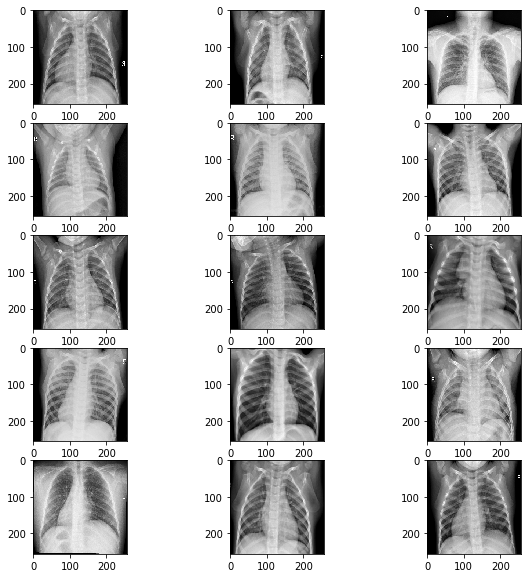

In [2]:
train,_,_ = image_paths()
normal_t,pneumonia_t = image_classes(train)

plot_images(normal_t)

## Pneumonia Cases

3875


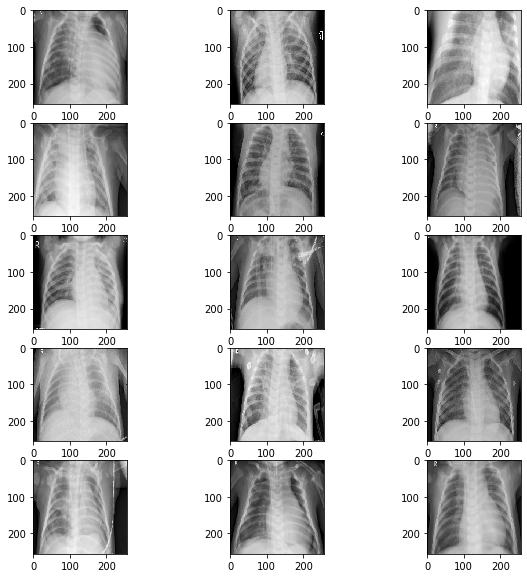

In [3]:
plot_images(pneumonia_t)

In [4]:
#load each model based on optimizer
from depthnet.model import DepthNet 

dn = DepthNet()
dn.initialize()
model_nadam = dn.load_model('DepthNet-16-2019-12-nadam_optimizer.h5')
model_adam = dn.load_model('DepthNet-16-2019-12-adam_optimizer.h5')
model_sgd = dn.load_model('DepthNet-16-2019-12-sgd_optimizer.h5')

E:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1type' 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
c_64_0 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
c_64_1 (Conv2D)              (None, 224, 224, 64)      36928     
_________________________________________________________________
mp_0 (MaxPooling2D)          (None, 112, 112, 64)      0         
_________________________________________________________________
c_128_0 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
c_128_1 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
mp_1 (MaxPooling2D)          (None, 56, 56, 128)       0     

In [5]:
import cv2

nadam_p = list()
adam_p = list()
sgd_p = list()
for i in range(len(images)):
    image = cv2.imread(str(images[i]))
    image = cv2.resize(image,(224,224))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = (image - np.mean(image))/np.std(image)
    image = np.array([image])
    nadam_p.append(model_nadam.predict(image)[0])
    adam_p.append(model_adam.predict(image)[0])
    sgd_p.append(model_sgd.predict(image)[0])

## Raw Predictions 

In [6]:
nadam_p

[array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0.00000013, 0.9999999 ], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32)]

In [7]:
adam_p

[array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32)]

In [8]:
from sklearn.metrics import confusion_matrix,classification_report

## Class Predictions and Relative Metrics

In [9]:
#actual class labels 0 => Predicted Normal - 1 => Predicted Pneumonia
actual_class_p = np.argmax(labels,axis=1)
print(actual_class_p)

[1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0]


In [10]:
#nadam optimizer results 
nadam_class_p = np.argmax(nadam_p,axis=1)
nadam_cm = confusion_matrix(y_true=actual_class_p,y_pred=nadam_class_p)
nadam_cr = classification_report(y_true=actual_class_p,y_pred=nadam_class_p)
print(nadam_class_p)
print(nadam_cm)
print(nadam_cr)

[1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0]
[[6 2]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [11]:
#adam optimizer results 
adam_class_p = np.argmax(adam_p,axis=1)
adam_cm = confusion_matrix(y_true=actual_class_p,y_pred=adam_class_p)
adam_cr = classification_report(y_true=actual_class_p,y_pred=adam_class_p)
print(adam_class_p)
print(adam_cm)
print(adam_cr)

[1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
[[8 0]
 [5 3]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.38      0.55         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



In [12]:
#sgd optimizer results
sgd_class_p = np.argmax(sgd_p,axis=1)
sgd_cm = confusion_matrix(y_true=actual_class_p,y_pred=sgd_class_p)
sgd_cr = classification_report(y_true=actual_class_p,y_pred=sgd_class_p)
print(sgd_class_p)
print(sgd_cm)
print(sgd_cr)

[1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0]
[[5 3]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



## Feature Map Visualization

We will plot the feature maps extracted from the 'c_512_0' layer.

### Pneumonia Case

E:\Downloads\chest-xray-pneumonia\chest_xray\val\PNEUMONIA\person1947_bacteria_4876.jpeg


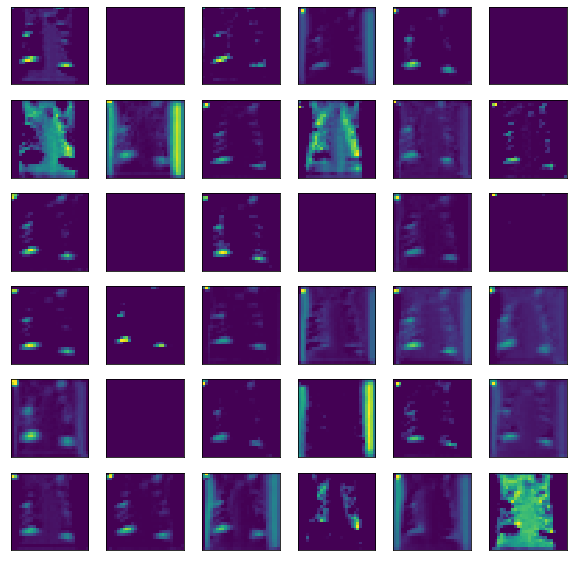

In [51]:
from tensorflow.keras.models import Model

feature_map = Model(inputs=model_nadam.inputs,outputs=model_nadam.get_layer('c_512_0').output)

image = cv2.imread(str(images[0]))
image = cv2.resize(image,(224,224))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = (image - np.mean(image))/np.std(image)
image = np.array([image])

rc = 6 #only plot 6x6=36 filters
i = 0 

f_map = feature_map.predict(image) #extracts feature maps for given image
print(images[0])

plt.figure(figsize=(10,10))
for _ in range(rc):
    for _ in range(rc):
        plt.subplot(rc,rc,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(f_map[0,:,:,i-1])
        i += 1
plt.show()

### Normal Case

E:\Downloads\chest-xray-pneumonia\chest_xray\val\NORMAL\NORMAL2-IM-1440-0001.jpeg


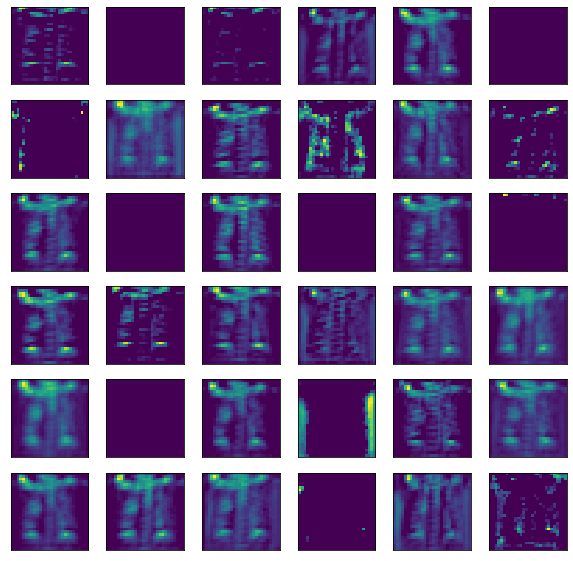

In [52]:
image = cv2.imread(str(images[2]))
image = cv2.resize(image,(224,224))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = (image - np.mean(image))/np.std(image)
image = np.array([image])

rc = 6 #only plot 6x6=36 filters
i = 0 

f_map = feature_map.predict(image) #extracts feature maps for given image
print(images[2])

plt.figure(figsize=(10,10))
for _ in range(rc):
    for _ in range(rc):
        plt.subplot(rc,rc,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(f_map[0,:,:,i-1])
        i += 1
plt.show()


## What's Next?

There is another dataset that is similar to this one (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview), however, the task involves segmentation exclusively. This was just a first step in aquiring a model that can be used as means to extract relevant features - now, all that will (hopefully) needed is to develop a decoder.  